# CMIP6 Rain and Wind Onset and Future Change

This script calculates the first date each grid cell receives 12mm of rainfall over 2 weeks, not followed by a similar dry spell, as well as the first date each grid cell has a 95th percentile daily mean wind speed in CMIP6 models. Then, differences between historical and past are plotted.
Data is limited to August through November. 
Because it is using high resolution data, this was run on a server. It can be run on a local machine, but will be very slow, and take up a lot of memory.



In [6]:
import xarray as xr
import cftime
import pandas as pd
import numpy as np
import netCDF4
import os
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.ticker import MultipleLocator
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
import matplotlib.colors

In [ ]:
for model in model_list:
    
    
    directory = model_directory+'/'+model+'/pr/historical/'
    pr_dir = directory+'/'+model+'_pr_1981_2013.nc'
    directory = model_directory+'/'+model+'/sfcWind/historical/'
    sfcWind_dir = directory+'/'+model+'_sfcWind_1981_2013.nc'
    pr = xr.open_dataset(pr_dir)
    sfcWind = xr.open_dataset(sfcWind_dir)
    
    #limit data to 1981-2010
    sfcWind = sfcWind.sel(day=slice('1981-01', '2010-12'))
    pr = pr.sel(day=slice('1981-01', '2010-12'))
    
    sfcWind_vals = sfcWind.wspd10mean
    pr_vals = pr.prec
    
    # calculating wind percentiles based on one year might cause issues, you need the entire dataset
    
    testing_percentile = .95
    
    months = [7,8,9,10,11,12]
    time_index = [i for i, month in enumerate(pr_vals.day.dt.month) if month in months]
    pr_vals = pr_vals.isel(day = time_index)
    pr_vals = pr_vals.rename({'day':'time'})
    
    
    UV = sfcWind_vals
    wind_prctiles = UV.quantile(testing_percentile,dim="day")
    months = [8,9,10,11,12]
    time_index = [i for i, month in enumerate(UV.day.dt.month) if month in months]
    UV = UV.isel(day = time_index)
    
    wd = xr.where(UV > wind_prctiles,1,0)
    wd = wd.rename({'day':'time'})
    
    
    # check wind before dry for each year
    
    fire_weather = []
    all_first_wd= []
    all_first_wet = []
    for i in range(len(wd.groupby('time.year'))):
        testyear = 1981+i
        # new dataset just for 1 year
        # wind
        wd_testing_year = wd.sel(time=wd.time.dt.year.isin([testyear]))
        first_wd = wd_testing_year.argmax('time')
        all_zeroes = (wd_testing_year==0).all(dim='time')
        new_first_wd = xr.where(all_zeroes,np.nan,first_wd)
        all_first_wd.append(new_first_wd)   
        
        
        # rain
        # Select the precipitation data for the testing year
        prcp_year = pr_vals.sel(time=pr_vals.time.dt.year.isin([testyear]))
        # gotta include july, then cut it out
        fall_prcp = prcp_year.sel(time=prcp_year['time.month'] >= 7)
        fall_prcp = fall_prcp.sel(time=fall_prcp['time.month'] < 12)
        # Select the 2-week periods
        fall_prcp_rolling_back = fall_prcp.rolling(time=14).sum(dim='time').fillna(0)
        # limit to august forward
        months = [8,9,10,11,12]
        time_index = [i for i, month in enumerate(fall_prcp_rolling_back.time.dt.month) if month in months]
        fall_prcp_rolling_back = fall_prcp_rolling_back.isel(time = time_index)
        
        fall_prcp_rolling_forward = fall_prcp.rolling(time=14,min_periods=1).sum(dim='time').fillna(0)
        time_index = [i for i, month in enumerate(fall_prcp_rolling_forward.time.dt.month) if month in months]
        fall_prcp_rolling_forward = fall_prcp_rolling_forward.isel(time = time_index)
        # back rolling above 12mm
        new_wet_cond = fall_prcp_rolling_back > 12
    
        # forward rolling under 12
        dry_spell = fall_prcp_rolling_forward < 12
    
        wet_cond_without_dry = new_wet_cond.where(~dry_spell).fillna(0)
    
        first_wet_week = wet_cond_without_dry.argmax('time')
        all_zeroes = (wet_cond_without_dry==0).all(dim='time')
        first_wet_week = xr.where(all_zeroes,np.nan,first_wet_week)
        all_first_wet.append(first_wet_week)
    
    first_wet_hist = xr.concat(all_first_wet,dim='newyear')
    first_wind_hist = xr.concat(all_first_wd,dim='newyear')
    #wetfile = '/vol/share/climate_lab2/Graham/Fire_circulation/Data/Downscaled/'+model+'/'+model+'_1981_2010_first_wet_nans.nc'
    #first_wet_hist.to_netcdf(wetfile)
    #windfile= '/vol/share/climate_lab2/Graham/Fire_circulation/Data/Downscaled/'+model+'/'+model+'_1981_2010_first_wind_nans.nc'
    #first_wind_hist.to_netcdf(windfile)
    
    data_dict_hist = {'first_wet_hist': first_wet_hist, 'first_wind_hist': first_wind_hist}
    dataset_hist = xr.Dataset(data_dict_hist)
    save_dir_hist = '/~/'+model+'/'+model+'_1981_2010_first_wet_and_wind_nans_dry_spell.nc'
    dataset_hist.to_netcdf(save_dir_hist)
    
    
    # ## load future data
    
    directory = model_directory+'/'+model+'/pr/ssp370/'
    pr_dir = directory+'/'+model+'_pr_2065_2099.nc'
    directory = model_directory+'/'+model+'/sfcWind/ssp370/'
    sfcWind_dir = directory+'/'+model+'_sfcWind_2065_2099.nc'
    pr = xr.open_dataset(pr_dir)
    sfcWind = xr.open_dataset(sfcWind_dir)
  
    sfcWind = sfcWind.sel(day=slice('2070-01', '2099-12'))
    pr = pr.sel(day=slice('2070-01', '2099-12'))
    
    sfcWind_vals = sfcWind.wspd10mean
    pr_vals = pr.prec
    
    
    
    months = [7,8,9,10,11,12]
    time_index = [i for i, month in enumerate(pr_vals.day.dt.month) if month in months]
    pr_vals = pr_vals.isel(day = time_index)
    pr_vals = pr_vals.rename({'day':'time'})
    
    
    UV = sfcWind_vals
    wind_prctiles = UV.quantile(testing_percentile,dim="day")
    months = [8,9,10,11,12]
    time_index = [i for i, month in enumerate(UV.day.dt.month) if month in months]
    UV = UV.isel(day = time_index)
    
    wd = xr.where(UV > wind_prctiles,1,0)
    wd = wd.rename({'day':'time'})
    
    
    # check wind before dry for each year
    
    fire_weather = []
    all_first_wd= []
    all_first_wet = []
    for i in range(len(wd.groupby('time.year'))):
        testyear = 2070+i
        # new dataset just for 1 year
        # wind
        wd_testing_year = wd.sel(time=wd.time.dt.year.isin([testyear]))
        first_wd = wd_testing_year.argmax('time')
        all_zeroes = (wd_testing_year==0).all(dim='time')
        new_first_wd = xr.where(all_zeroes,np.nan,first_wd)
        all_first_wd.append(new_first_wd)   
        
        
        # rain
        # Select the precipitation data for the testing year
        prcp_year = pr_vals.sel(time=pr_vals.time.dt.year.isin([testyear]))
        # gotta include july, then cut it out
        fall_prcp = prcp_year.sel(time=prcp_year['time.month'] >= 7)
        fall_prcp = fall_prcp.sel(time=fall_prcp['time.month'] < 12)
        # Select the 2-week periods
        fall_prcp_rolling_back = fall_prcp.rolling(time=14).sum(dim='time').fillna(0)
        # limit to august forward
        months = [8,9,10,11,12]
        time_index = [i for i, month in enumerate(fall_prcp_rolling_back.time.dt.month) if month in months]
        fall_prcp_rolling_back = fall_prcp_rolling_back.isel(time = time_index)
        
        fall_prcp_rolling_forward = fall_prcp.rolling(time=14,min_periods=1).sum(dim='time').fillna(0)
        time_index = [i for i, month in enumerate(fall_prcp_rolling_forward.time.dt.month) if month in months]
        fall_prcp_rolling_forward = fall_prcp_rolling_forward.isel(time = time_index)
        # back rolling above 12mm
        new_wet_cond = fall_prcp_rolling_back > 12
    
        # forward rolling under 12
        dry_spell = fall_prcp_rolling_forward < 12
    
        wet_cond_without_dry = new_wet_cond.where(~dry_spell).fillna(0)
    
        first_wet_week = wet_cond_without_dry.argmax('time')
        all_zeroes = (wet_cond_without_dry==0).all(dim='time')
        first_wet_week = xr.where(all_zeroes,np.nan,first_wet_week)
        all_first_wet.append(first_wet_week)
    
    first_wet_fut = xr.concat(all_first_wet,dim='newyear')
    first_wind_fut = xr.concat(all_first_wd,dim='newyear')

    
    data_dict_fut = {'first_wet_fut': first_wet_fut, 'first_wind_fut': first_wind_fut}
    dataset_fut = xr.Dataset(data_dict_fut)
    save_dir_fut = '/~/'+model+'/'+model+'_2070_2099_first_wet_and_wind_nans_dry_spell.nc'
    dataset_fut.to_netcdf(save_dir_fut)

# Plotting

## Historical Model Rain Onset

In [3]:
model_directory = '/model_directory'
model_list = [folder for folder in os.listdir(model_directory) if os.path.isdir(os.path.join(model_directory, folder)) and folder != ".DS_Store"]
coords = xr.open_dataset('/Users/gt7/Desktop/Research/downscaled_data/coords/wrfinput_d02_coord.nc')

/Users/gt7/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/xarray/backends/plugins.py:68: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [4]:
# Custom colormap for rain onset
twelve_color_cmap3 = matplotlib.colors.ListedColormap(["snow","lemonchiffon","lightcoral","lightsalmon","gold",
                                                                   "palegreen","mediumseagreen","seagreen",
                                                                   "cornflowerblue","royalblue","slateblue"])

/Users/gt7/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
/Users/gt7/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


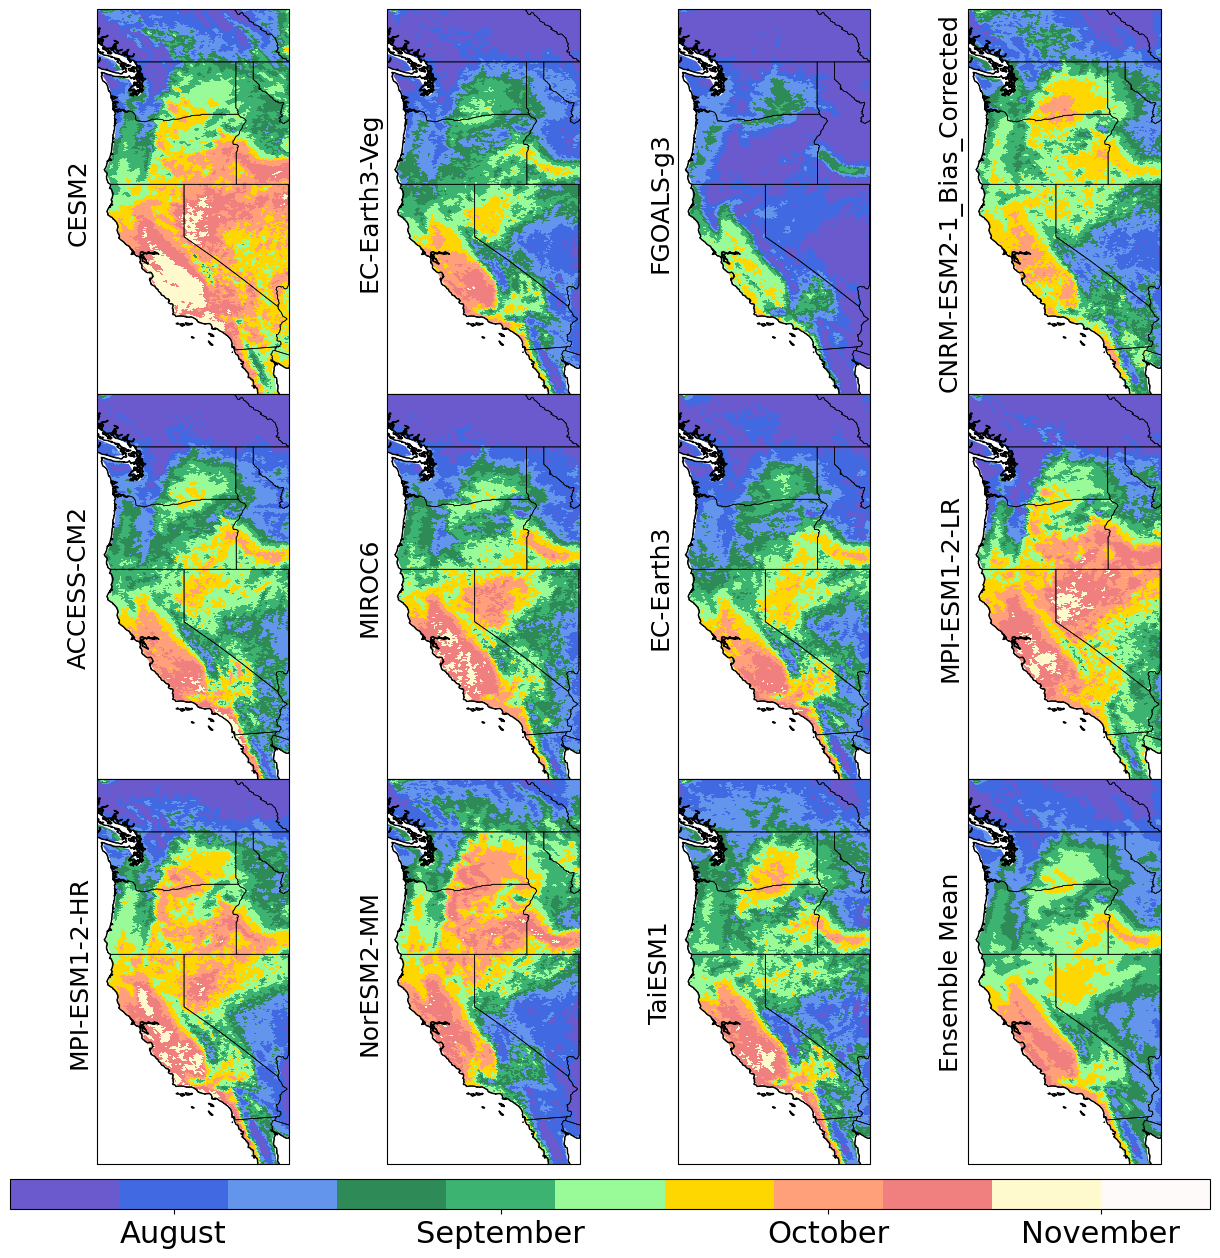

In [5]:
# calculate all of them and add them to an array, then add the ensemble mean to the array
from matplotlib.ticker import MultipleLocator
fig,ax = plt.subplots(3,4,figsize=[15,15],constrained_layout=True)
all_models = []
for model in model_list:
    file = model_directory+'/'+model+'/'+model+'_1981_2010_first_wet_and_wind_dry_spell.nc'
    dataset = xr.open_dataset(file)
    first_wet_hist = dataset.first_wet_hist  

    first_wet_mean = first_wet_hist.mean(dim='newyear')
    all_models.append(first_wet_mean)
all_models = xr.concat(all_models,dim='model')
ensemble_mean = all_models.mean(dim='model')

all_models_new = xr.concat([all_models,ensemble_mean],dim='model')
model_list.append('Ensemble Mean')

for x,model in enumerate(model_list):
    first_wet_mean = all_models_new[x]
    ax = plt.subplot(3, 4, x+1, projection=ccrs.PlateCarree())
    im = ax.pcolormesh(coords['lon2d'],coords['lat2d'],first_wet_mean,cmap=twelve_color_cmap3.reversed(),vmin=0,vmax=110)
    ocean = cfeature.NaturalEarthFeature('physical', 'ocean', '110m', edgecolor='face', facecolor='white')
    ax.add_feature(ocean)
    #plt.title(model)
    ax.coastlines()
    ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=.5)
    ax.set_ylim(30,52)
    ax.set_xlim(-125,-114)
    ax.set_ylabel(model,fontsize=18)
    ax.yaxis.set_label_position("left")
    ax.tick_params(axis='y')
    ax.set_xticks([])
    ax.set_yticks([])

    
fig.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
cbar_ax = fig.add_axes([0.1, 0.08, 0.8, 0.02]) 
cbar = fig.colorbar(im,cax=cbar_ax,orientation='horizontal')
tick_positions = [15, 45, 75, 100]
tick_labels = ["August", "September", "October", "November"]
cbar.set_ticks(tick_positions)
cbar.set_ticklabels(tick_labels)
cbar.ax.tick_params(labelsize=22) 
plt.show()

## Future Change in Rain Onset Date 
### Significance hatching using a mann whitney U test

In [2]:
model_directory = '/model_directory/'
model_list = [folder for folder in os.listdir(model_directory) if os.path.isdir(os.path.join(model_directory, folder)) and folder != ".DS_Store"]
coords = xr.open_dataset('/~/wrfinput_d02_coord.nc')

/Users/gt7/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/xarray/backends/plugins.py:68: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [3]:
# Define a function to apply the Mann-Whitney U test to each latitude and longitude pair
from scipy.stats import rankdata
from scipy.stats import mannwhitneyu
def mannwhitneyu_lat_lon(a, b, lat2d, lon2d):
    # Mask NaN values in the input arrays
    a_masked = np.ma.masked_invalid(a)
    b_masked = np.ma.masked_invalid(b)

    # Initialize an array to store the p-values
    p_value = np.empty(a_masked.shape[-2:])
    p_value[:] = np.nan

    # Iterate over each grid point and compute the Mann-Whitney U test
    for i in range(a_masked.shape[-2]):
        for j in range(a_masked.shape[-1]):
            a_non_empty = a_masked[:, i, j].compressed()
            b_non_empty = b_masked[:, i, j].compressed()
            if len(a_non_empty) > 0 and len(b_non_empty) > 0:
                _, p_value[i, j] = mannwhitneyu(a_non_empty, b_non_empty)

    # Create a DataArray with the computed p-values
    p_value_da = xr.DataArray(p_value, dims=('lat2d', 'lon2d'), coords={'lat2d': lat2d, 'lon2d': lon2d})

    return p_value_da

In [4]:
# calculate significance
all_models_hist = []
for model in model_list:
    file = model_directory+'/'+model+'/'+model+'_1981_2010_first_wet_and_wind_dry_spell.nc'
    dataset = xr.open_dataset(file)
    first_wet_hist = dataset.first_wet_hist  
    all_models_hist.append(first_wet_hist)
    
all_models_hist = xr.concat(all_models_hist,dim='model')
ensemble_mean = all_models_hist.mean(dim='model')

all_models_hist = xr.concat([all_models_hist,ensemble_mean],dim='model')

# fut
all_models_fut = []
for model in model_list:
    file = model_directory+'/'+model+'/'+model+'_2070_2099_first_wet_and_wind_dry_spell.nc'
    dataset = xr.open_dataset(file)
    first_wet_fut = dataset.first_wet_fut  
    all_models_fut.append(first_wet_fut)
    
all_models_fut = xr.concat(all_models_fut,dim='model')
ensemble_mean = all_models_fut.mean(dim='model')

all_models_fut = xr.concat([all_models_fut,ensemble_mean],dim='model')
model_list.append('Ensemble Mean')

all_sigs = []
all_diffs = []
for x,model in enumerate(model_list):
    
    # Test significance
    array1 = all_models_hist[x]
    array2 = all_models_fut[x]

    wet_diff = array2 - array1
    mean_wet_diff = wet_diff.mean(dim='newyear')
    all_diffs.append(mean_wet_diff)
    
    p_values = xr.apply_ufunc(
        mannwhitneyu_lat_lon, 
        array1, 
        array2, 
        input_core_dims=[['newyear', 'lat2d', 'lon2d'], ['newyear', 'lat2d', 'lon2d']],
        # Pass lat2d and lon2d as additional arguments
        kwargs={'lat2d': array1.lat2d, 'lon2d': array1.lon2d},
        output_core_dims=[['lat2d', 'lon2d']], 
        dask='parallelized',  # use parallel computation with Dask
        output_dtypes=[float]
    )
    sig_vals = p_values < 0.1
    #sig_diffs = sig_vals * mean_wet_diff
    all_sigs.append(sig_vals)
    
all_sigs = xr.concat(all_sigs,dim='model')
all_diffs = xr.concat(all_diffs,dim='model')

sig_sum = all_sigs.sum(dim='model')

### Plotting

In [7]:
segment_map3 = matplotlib.colors.ListedColormap(["royalblue","cornflowerblue","lightskyblue","lightcyan","mistyrose","lightcoral","indianred","firebrick"])

/Users/gt7/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1508: UserWarning: linewidths is ignored by contourf
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
/Users/gt7/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
/Users/gt7/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


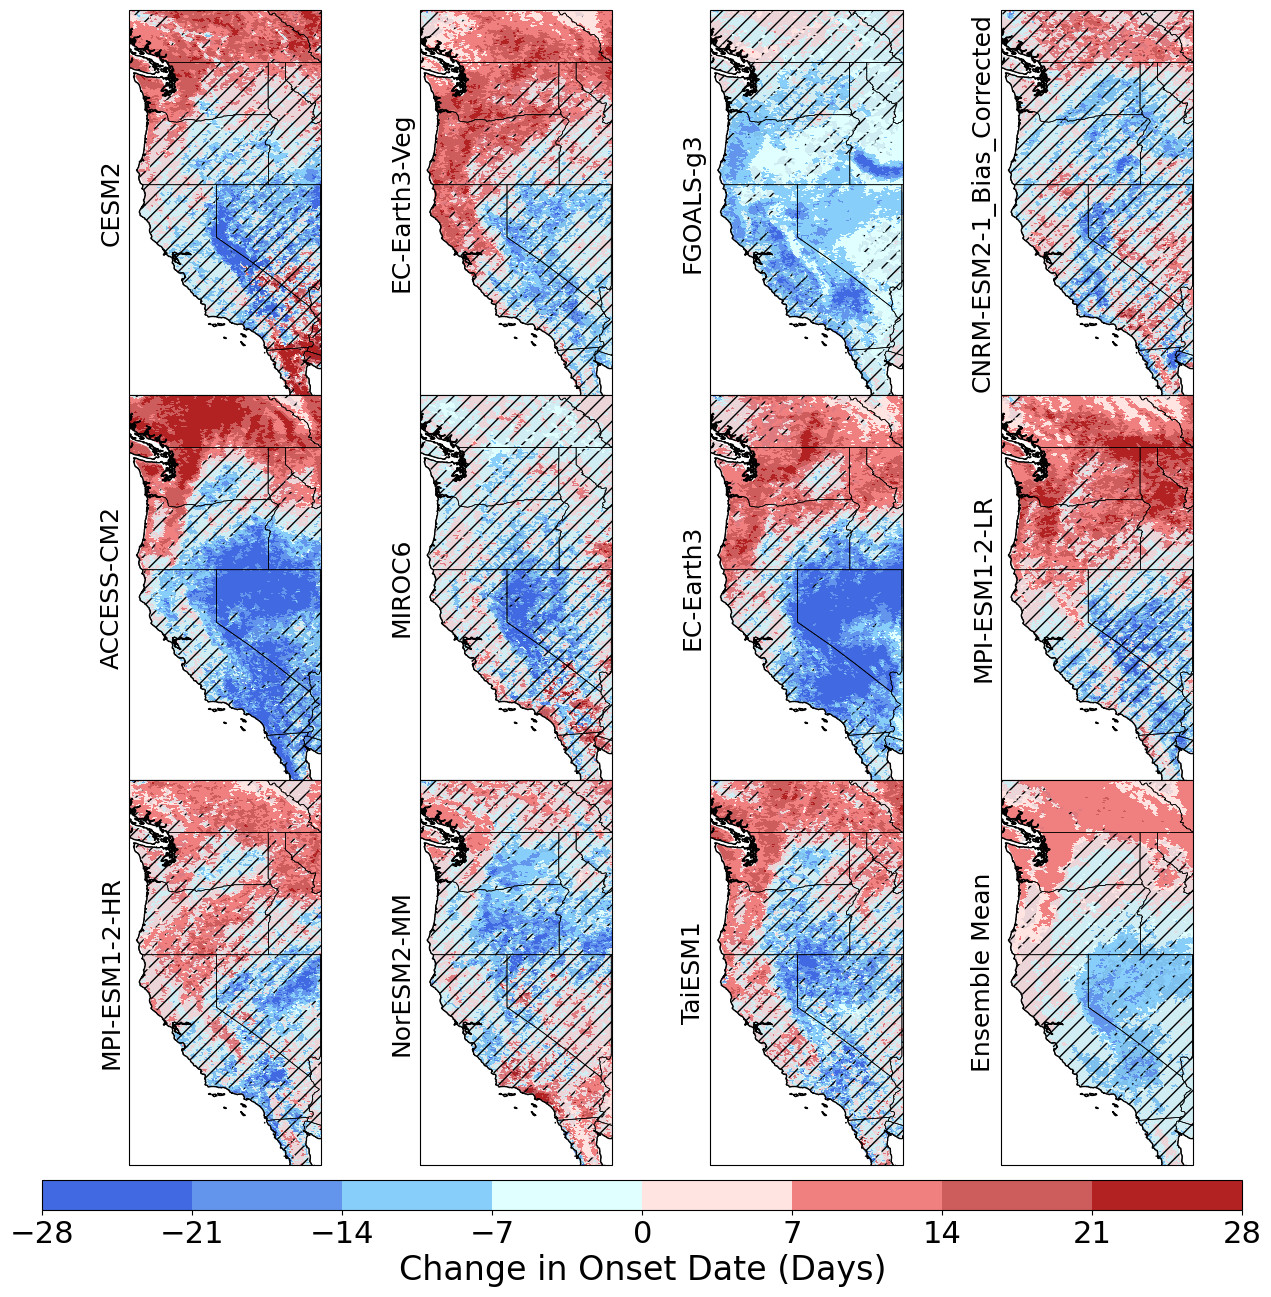

In [8]:
half_count = sig_sum>=6
fig,ax = plt.subplots(3,4,figsize=[15,15],constrained_layout=True)
for x,model in enumerate(model_list):   
    mean_wet_diff = all_diffs[x]
    if x < 11:
        sig_vals = all_sigs[x]
    else:
        sig_vals = half_count
    
    ax = plt.subplot(3, 4, x+1, projection=ccrs.PlateCarree())
    im = ax.pcolormesh(coords['lon2d'],coords['lat2d'],mean_wet_diff,cmap=segment_map3,vmin=-28,vmax=28)
    masked_array = np.where(sig_vals.values, np.nan, 1)
    plt.contourf(coords['lon2d'], coords['lat2d'], masked_array, hatches=['//'], alpha=0.1, linewidths=0.1)
    ocean = cfeature.NaturalEarthFeature('physical', 'ocean', '110m', edgecolor='face', facecolor='white')
    ax.add_feature(ocean)
    #plt.title(model)
    ax.coastlines()
    ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=.5)
    ax.set_ylim(30,52)
    ax.set_xlim(-125,-114)
    ax.set_ylabel(model,fontsize=18)
    ax.yaxis.set_label_position("left")
    ax.tick_params(axis='y')
    ax.set_xticks([])
    ax.set_yticks([])
    
fig.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
cbar_ax = fig.add_axes([0.1, 0.08, 0.8, 0.02]) 
cbar = plt.colorbar(im,ticks=[-28, -21, -14, -7, 0, 7, 14, 21, 28], cax=cbar_ax,orientation='horizontal')
cbar.ax.tick_params(labelsize=22) 
cbar.set_label('Change in Onset Date (Days)',fontsize=24)
plt.show()

# Wind Onset

## Historical Model Wind Onset

In [6]:
model_directory = '/model_directory/'
model_list = [folder for folder in os.listdir(model_directory) if os.path.isdir(os.path.join(model_directory, folder)) and folder != ".DS_Store"]
coords = xr.open_dataset('/~/wrfinput_d02_coord.nc')

In [7]:
five_color_cmap = matplotlib.colors.ListedColormap(["lightcoral","gold","mediumseagreen","royalblue"])

/Users/gt7/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
/Users/gt7/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


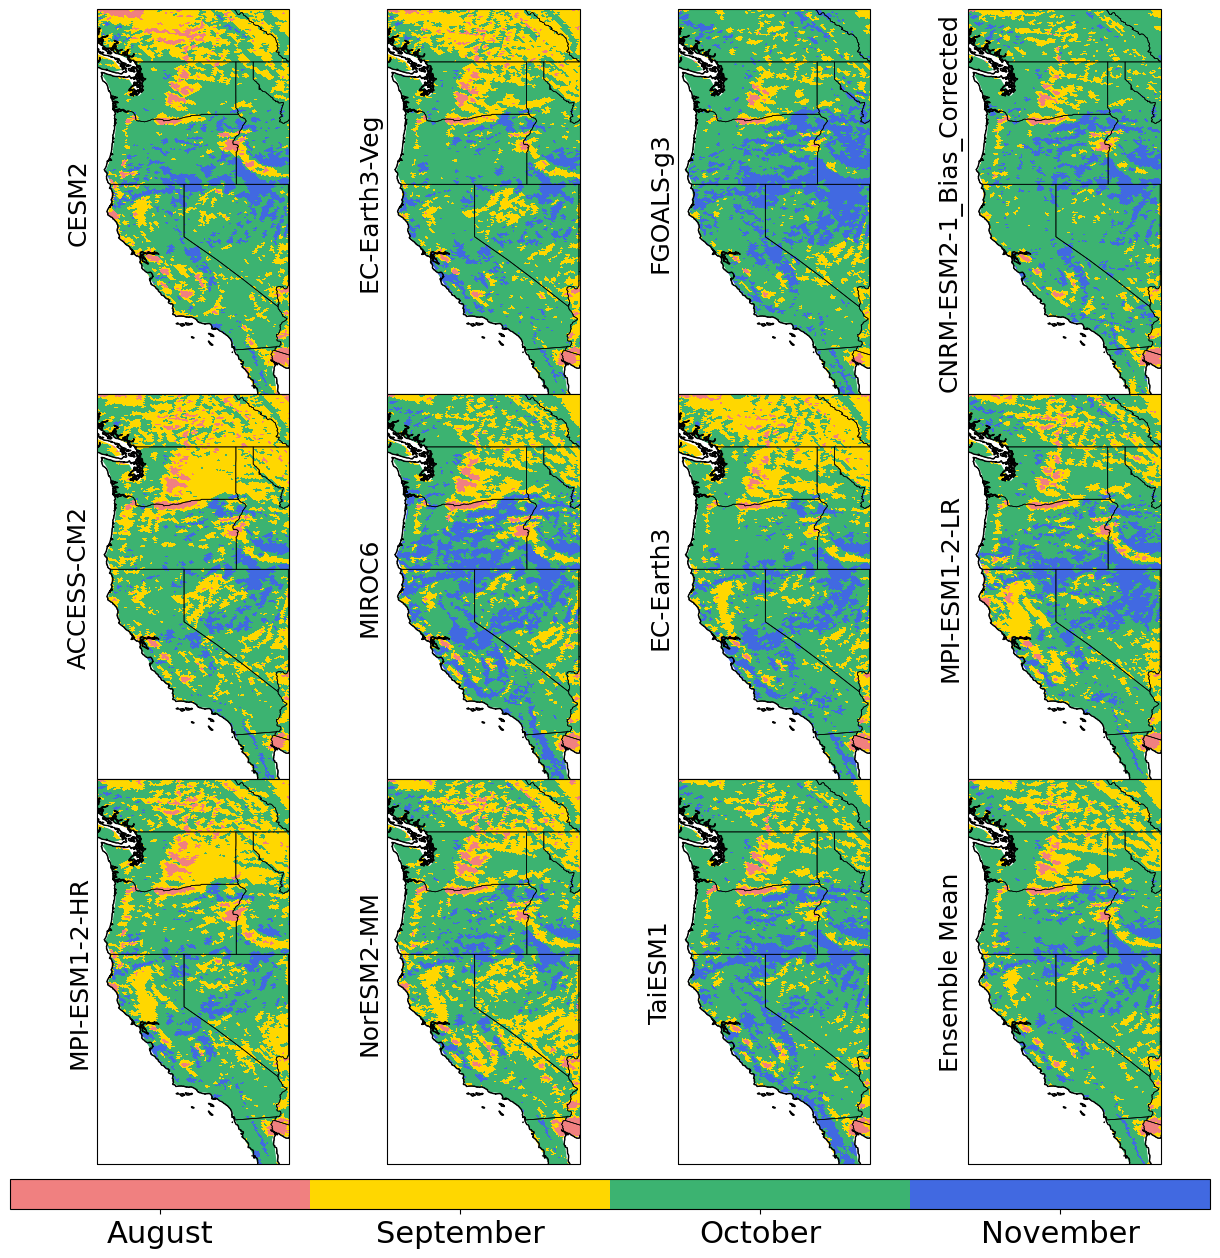

In [8]:
# calculate all of them and add them to an array, then add the ensemble mean to the array

fig,ax = plt.subplots(3,4,figsize=[15,15],constrained_layout=True)
all_models = []
for model in model_list:
    file = model_directory+'/'+model+'/'+model+'_1981_2010_first_wet_and_wind.nc'
    dataset = xr.open_dataset(file)
    first_wet_hist = dataset.first_wind_hist  

    first_wet_mean = first_wet_hist.mean(dim='newyear')
    all_models.append(first_wet_mean)
all_models = xr.concat(all_models,dim='model')
ensemble_mean = all_models.mean(dim='model')

all_models_new = xr.concat([all_models,ensemble_mean],dim='model')
model_list.append('Ensemble Mean')

for x,model in enumerate(model_list):
    first_wet_mean = all_models_new[x]
    ax = plt.subplot(3, 4, x+1, projection=ccrs.PlateCarree())
    im = ax.pcolormesh(coords['lon2d'],coords['lat2d'],first_wet_mean,cmap=five_color_cmap,vmin=0,vmax=120)
    ocean = cfeature.NaturalEarthFeature('physical', 'ocean', '110m', edgecolor='face', facecolor='white')
    ax.add_feature(ocean)
    #plt.title(model)
    ax.coastlines()
    ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=.5)
    ax.set_ylim(30,52)
    ax.set_xlim(-125,-114)
    ax.set_ylabel(model,fontsize=18)
    ax.yaxis.set_label_position("left")
    ax.tick_params(axis='y')
    ax.set_xticks([])
    ax.set_yticks([])

    
fig.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
cbar_ax = fig.add_axes([0.1, 0.08, 0.8, 0.02]) 
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
#tick_spacing = 30
#cbar.locator = MultipleLocator(base=tick_spacing)
#cbar.update_ticks()
tick_positions = [15, 45, 75, 105]
tick_labels = ["August", "September", "October", "November"]
cbar.set_ticks(tick_positions)
cbar.set_ticklabels(tick_labels)
cbar.ax.tick_params(labelsize=22) 
plt.show()

## Future Wind Start

In [10]:
model_directory = '/model_directory/'
model_list = [folder for folder in os.listdir(model_directory) if os.path.isdir(os.path.join(model_directory, folder)) and folder != ".DS_Store"]
coords = xr.open_dataset('/~/wrfinput_d02_coord.nc')

/Users/gt7/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
/Users/gt7/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


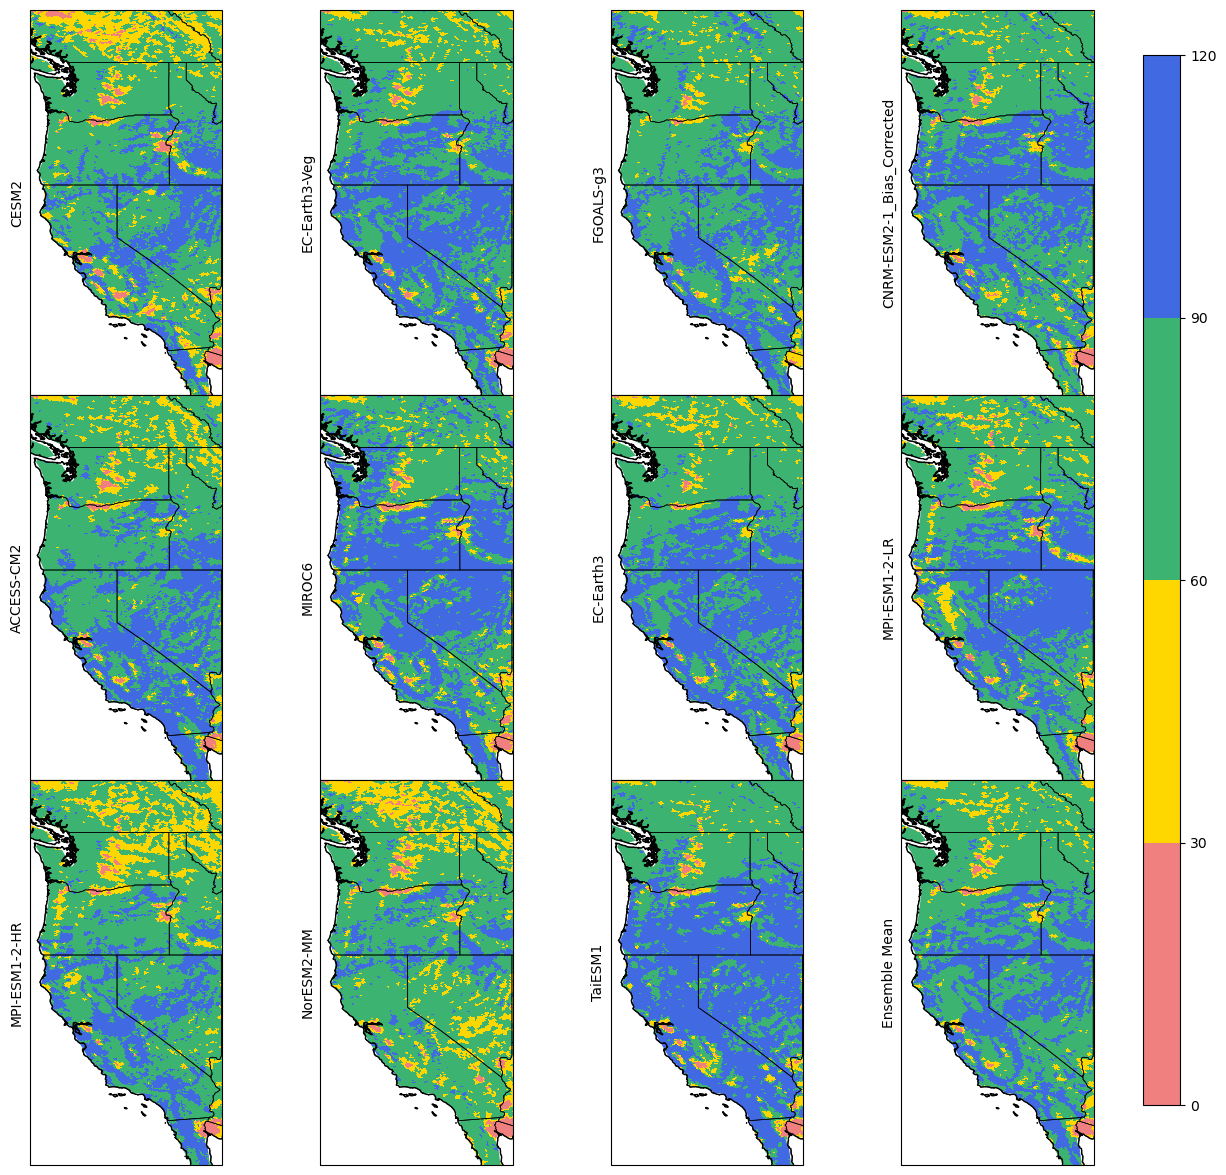

In [11]:
# calculate all of them and add them to an array, then add the ensemble mean to the array
#model_list.remove('Ensemble Mean')
fig,ax = plt.subplots(3,4,figsize=[15,15],constrained_layout=True)
all_models = []
for model in model_list:
    file = model_directory+'/'+model+'/'+model+'_2070_2099_first_wet_and_wind_nans.nc'
    dataset = xr.open_dataset(file)
    first_wet_hist = dataset.first_wind_fut  

    first_wet_mean = first_wet_hist.mean(dim='newyear')
    all_models.append(first_wet_mean)
all_models = xr.concat(all_models,dim='model')
ensemble_mean = all_models.mean(dim='model')

all_models_new = xr.concat([all_models,ensemble_mean],dim='model')
model_list.append('Ensemble Mean')

for x,model in enumerate(model_list):
    first_wet_mean = all_models_new[x]
    ax = plt.subplot(3, 4, x+1, projection=ccrs.PlateCarree())
    im = ax.pcolormesh(coords['lon2d'],coords['lat2d'],first_wet_mean,cmap=five_color_cmap,vmin=0,vmax=120)
    ocean = cfeature.NaturalEarthFeature('physical', 'ocean', '110m', edgecolor='face', facecolor='white')
    ax.add_feature(ocean)
    #plt.title(model)
    ax.coastlines()
    ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=.5)
    ax.set_ylim(30,52)
    ax.set_xlim(-125,-114)
    ax.set_ylabel(model)
    ax.yaxis.set_label_position("left")
    ax.tick_params(axis='y')
    ax.set_xticks([])
    ax.set_yticks([])

    
fig.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
cbar_ax = fig.add_axes([0.9, 0.15, 0.025, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
tick_spacing = 30
cbar.locator = MultipleLocator(base=tick_spacing)
cbar.update_ticks()
plt.show()

# Future Change in Wind Onset Date

## Significance hatching

In [9]:
model_directory = '/model_directory/'
model_list = [folder for folder in os.listdir(model_directory) if os.path.isdir(os.path.join(model_directory, folder)) and folder != ".DS_Store"]
coords = xr.open_dataset('/~/wrfinput_d02_coord.nc')

In [10]:
# Define a function to apply the Mann-Whitney U test to each latitude and longitude pair
from scipy.stats import rankdata
from scipy.stats import mannwhitneyu
def mannwhitneyu_lat_lon(a, b, lat2d, lon2d):
    # Mask NaN values in the input arrays
    a_masked = np.ma.masked_invalid(a)
    b_masked = np.ma.masked_invalid(b)

    # Initialize an array to store the p-values
    p_value = np.empty(a_masked.shape[-2:])
    p_value[:] = np.nan

    # Iterate over each grid point and compute the Mann-Whitney U test
    for i in range(a_masked.shape[-2]):
        for j in range(a_masked.shape[-1]):
            a_non_empty = a_masked[:, i, j].compressed()
            b_non_empty = b_masked[:, i, j].compressed()
            if len(a_non_empty) > 0 and len(b_non_empty) > 0:
                _, p_value[i, j] = mannwhitneyu(a_non_empty, b_non_empty)

    # Create a DataArray with the computed p-values
    p_value_da = xr.DataArray(p_value, dims=('lat2d', 'lon2d'), coords={'lat2d': lat2d, 'lon2d': lon2d})

    return p_value_da

In [11]:
# hist
#model_list.remove('Ensemble Mean')
all_models_hist = []
for model in model_list:
    file = model_directory+'/'+model+'/'+model+'_1981_2010_first_wet_and_wind.nc'
    dataset = xr.open_dataset(file)
    first_wet_hist = dataset.first_wind_hist  
    all_models_hist.append(first_wet_hist)
    
all_models_hist = xr.concat(all_models_hist,dim='model')
ensemble_mean = all_models_hist.mean(dim='model')

all_models_hist = xr.concat([all_models_hist,ensemble_mean],dim='model')

# fut
all_models_fut = []
for model in model_list:
    file = model_directory+'/'+model+'/'+model+'_2070_2099_first_wet_and_wind.nc'
    dataset = xr.open_dataset(file)
    first_wet_fut = dataset.first_wind_fut  
    all_models_fut.append(first_wet_fut)
    
all_models_fut = xr.concat(all_models_fut,dim='model')
ensemble_mean = all_models_fut.mean(dim='model')

all_models_fut = xr.concat([all_models_fut,ensemble_mean],dim='model')
model_list.append('Ensemble Mean')



all_diffs = []
all_sigs = []

for x,model in enumerate(model_list):
    
    # Test significance
    array1 = all_models_hist[x]
    array2 = all_models_fut[x]

    wet_diff = array2 - array1
    mean_wet_diff = wet_diff.mean(dim='newyear')
    all_diffs.append(mean_wet_diff)
    
    p_values = xr.apply_ufunc(
        mannwhitneyu_lat_lon, 
        array1, 
        array2, 
        input_core_dims=[['newyear', 'lat2d', 'lon2d'], ['newyear', 'lat2d', 'lon2d']],
        # Pass lat2d and lon2d as additional arguments
        kwargs={'lat2d': array1.lat2d, 'lon2d': array1.lon2d},
        output_core_dims=[['lat2d', 'lon2d']], 
        dask='parallelized',  # use parallel computation with Dask
        output_dtypes=[float]
    )
    sig_vals = p_values < 0.1
    
    all_sigs.append(sig_vals)
    
all_sigs = xr.concat(all_sigs,dim='model')
all_diffs = xr.concat(all_diffs,dim='model')

sig_sum = all_sigs.sum(dim='model')

## Plotting

/Users/gt7/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1508: UserWarning: linewidths is ignored by contourf
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
/Users/gt7/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
/Users/gt7/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


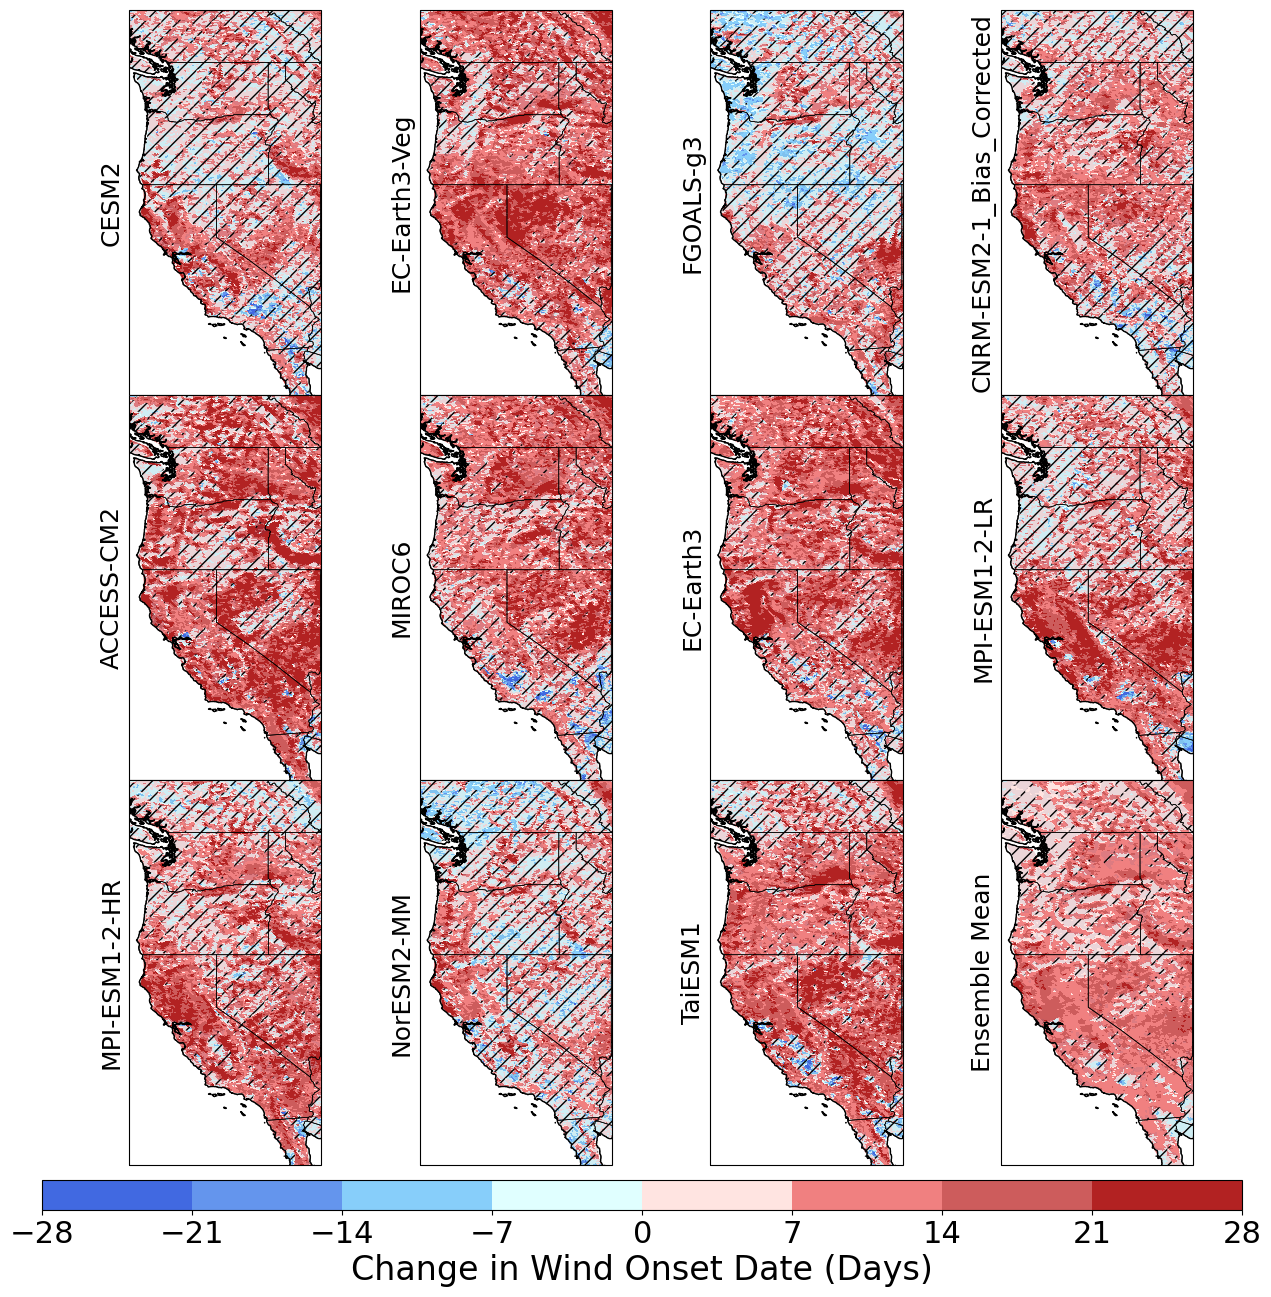

In [12]:
half_count = sig_sum>=6
fig,ax = plt.subplots(3,4,figsize=[15,15],constrained_layout=True)
for x,model in enumerate(model_list):   
    mean_wet_diff = all_diffs[x]
    if x < 11:
        sig_vals = all_sigs[x]
    else:
        sig_vals = half_count   
    ax = plt.subplot(3, 4, x+1, projection=ccrs.PlateCarree())
    im = ax.pcolormesh(coords['lon2d'],coords['lat2d'],mean_wet_diff,cmap=segment_map3,vmin=-28, vmax=28)
    masked_array = np.where(sig_vals.values, np.nan,1)
    plt.contourf(coords['lon2d'], coords['lat2d'], masked_array, hatches=['//'], alpha=0.1, linewidths=0.1)
    ocean = cfeature.NaturalEarthFeature('physical', 'ocean', '110m', edgecolor='face', facecolor='white')
    ax.add_feature(ocean)
    #plt.title(model)
    ax.coastlines()
    ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=.5)
    ax.set_ylim(30,52)
    ax.set_xlim(-125,-114)
    ax.set_ylabel(model,fontsize=18)
    ax.yaxis.set_label_position("left")
    ax.tick_params(axis='y')
    ax.set_xticks([])
    ax.set_yticks([])
    
fig.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
cbar_ax = fig.add_axes([0.1, 0.08, 0.8, 0.02]) 
cbar = plt.colorbar(im,ticks=[-28, -21, -14, -7, 0, 7, 14, 21, 28], cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=22) 
cbar.set_label('Change in Wind Onset Date (Days)',fontsize=24)
#cbar.ax.tick_params(labelsize=24)
plt.show()